This is the main file used to train and test the Unet.

As some cuda statements are hardcoded. This code will not run on CPU 

 # $\color{orange}{\text{Set paths}}$

In [3]:
# Mount drive if using colab 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
helper_path = '/content/drive/My Drive/02456_DL_project/GITHUB/02456DL/metrics/'
image_path = '/content/drive/My Drive/02456_DL_project/GITHUB/02456DL/data'
model_path = '/content/drive/My Drive/02456_DL_project/GITHUB/02456DL/models/unet/'

 # $\color{orange}{\text{Imports}}$ 

 ## $\color{purple}{\text{Regular packages}}$

In [5]:
# Install autotime to see how long time it takes for a cell to run
!pip install ipython-autotime

In [6]:
# Notebook specific
%load_ext autotime
%matplotlib inline

# General
import random
import numpy as np
import pandas as pd
import os
import random

# sklearn 
from sklearn.model_selection import StratifiedShuffleSplit

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.nn import Conv2d, MaxPool2d
from torch.nn.functional import relu
from torch.autograd import Variable
import torchvision.transforms as T

# Graph and image
import matplotlib.pyplot as plt
import glob
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.measure import label
import albumentations as A
from IPython.display import clear_output
from PIL import Image

/content/scikit-image/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


time: 1.1 s


 ## $\color{purple}{\text{Packages needed for testing}}$

In [7]:
# Install developer version of scikit image
#os.chdir("/content")
#!git clone https://github.com/scikit-image/scikit-image.git
#os.chdir("/content/scikit-image")
#!pip install -e .

# Force restart
#os._exit(0)

time: 1.74 ms


In [8]:
# Check version is now 18
!pip show scikit-image

Name: scikit-image
Version: 0.19.0.dev0
Summary: Image processing in Python
Home-page: https://scikit-image.org
Author: None
Author-email: None
License: Modified BSD
Location: /content/scikit-image
Requires: numpy, scipy, matplotlib, networkx, pillow, imageio, tifffile, PyWavelets
Required-by: keras-vis, imgaug
time: 1.93 s


In [9]:
# Import packages for test
from PIL import Image
from skimage.measure import label
from skimage.metrics import hausdorff_distance

# Wrap metrics around path to import it
os.chdir(helper_path)
from binary_metrics import BinaryImageMetrics

time: 3.46 s


 ## $\color{purple}{\text{Various small helper functions }}$

In [10]:
def tensor_to_binary(tensor):
    # we create a copy of the original tensor,
    # because of the way we are replacing them.
    res = tensor.clone()
    res[tensor >= 0.5] = 1
    res[tensor < 0.5] = 0
    return res

def to_cuda(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

def get_masks(batch):
    return to_cuda(Variable(torch.from_numpy(batch['mask'])))

def get_input(batch):
    return {'x_img': to_cuda(Variable(torch.from_numpy(batch['images'])))}

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

time: 12 ms


 # $\color{orange}{\text{Load and process data}}$

 ## $\color{purple}{\text{Functions}}$

### 1. Loads all paths of images

In [11]:
def image_pathloader(image_path):
  
  # Set training and test data paths
  training_path = image_path + '/train'
  test_path = image_path + '/test'

  # Glob the training data and load a single image path
  training_paths = glob.glob(training_path + "/*.bmp")
  test_paths = glob.glob(test_path + "/*.bmp")
  print("The number of training images:", len(training_paths),"\n")
  print("The number of test images:", len(test_paths),"\n")

  # Nr traning images
  nr_train_images = int(len(training_paths)/2)

  # Get all training images
  training_paths_col = [0] * nr_train_images

  for i in range(0,nr_train_images,1):
    training_paths_col[i] = training_path + "/train_{}".format(i+1) + ".bmp"

  # Annonated paths
  training_paths_anno = [x.replace(".bmp","_anno.bmp") for x in training_paths_col]

  # Nr traning images

  nr_testA_images, nr_testB_images = 0, 0
  for i in test_paths:
    if str.find(i,"testA") > 0:
      nr_testA_images += 1
    else:
      nr_testB_images += 1

  # Test A
  testA_images_paths = [0] * int(nr_testA_images/2)

  for i in range(0,int(nr_testA_images/2),1):
    testA_images_paths[i] = test_path + "/testA_{}".format(i+1) + ".bmp"

  # Annonated paths
  testA_images_paths_anno = [x.replace(".bmp","_anno.bmp") for x in testA_images_paths]

  # Test B
  testB_images_paths = [0] * int(nr_testB_images/2)

  for i in range(0,int(nr_testB_images/2),1):
    testB_images_paths[i] = test_path + "/testB_{}".format(i+1) + ".bmp"

  # Annonated paths
  testB_images_paths_anno = [x.replace(".bmp","_anno.bmp") for x in testB_images_paths]

  test_paths_col = testA_images_paths + testB_images_paths

  test_paths_anno = testA_images_paths_anno + testB_images_paths_anno

  print("The number of colour training images:", len(training_paths_col),"\n")
  print("The number of annotated training images:", len(training_paths_anno),"\n")
  print("The number of colour test images:", len(test_paths_col),"\n")
  print("The number of annotated test images:", len(test_paths_anno),"\n")

  # Zipping training and test image and associated mask paths into a list of tuples with a corresponding idx for each image
  train = list(zip(list(range(0,85)), training_paths_col, training_paths_anno))
  test = list(zip(list(range(0,85)), test_paths_col, test_paths_anno))

  testA = list(zip(range(0,len(testA_images_paths)), testA_images_paths, testA_images_paths_anno))
  testB = list(zip(range(0,len(testB_images_paths)), testB_images_paths, testB_images_paths_anno))

  return train, testA, testB

time: 56.7 ms


### 2. Class that extracts the actual images 

In [12]:
class GlaSDataset_UNet(torch.utils.data.Dataset):

  def __init__(self, data, augmentor=None, re_size = 512):
        self.augmentor = augmentor
        self.re_size = re_size
        # load all image files, sorting them to
        # ensure that they are aligned
        unzip = list(zip(*data))
        self.idx = unzip[0]
        self.imgs = unzip[1]
        self.masks = unzip[2]

  def __getitem__(self, idx):
    img_path = self.imgs[idx]
    mask_path = self.masks[idx]
    # Use PIL images as they are compatiple with pyTorch
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)
    img = np.array(img)
    mask = np.array(mask)
    obj_ids = np.unique(mask)[1:]

    # we standardize test data by the train statistics as we assume train and test data come from the same distribution.
    #data_set_mean = np.array([200.79152, 130.34973, 200.20961]) # hardcoded
    #data_set_std = np.array([39.208782, 53.638294, 28.703402])  # hardcoded

    #img = (img-data_set_mean)/data_set_std

    # Data augmentation
    if self.augmentor is not None:
      img, mask = self.augmentor(img, mask, self.re_size)

    # Handles test images as well
    if (img.shape[0] is not self.re_size) and (img.shape[1] is not self.re_size):
     img = resize(img, (self.re_size, self.re_size), anti_aliasing=False)
     mask = resize(mask, (self.re_size, self.re_size), anti_aliasing=False)
     crop = False
    else:
      crop = True

    # Make mask binary (black(0)/white(1))
    mask[mask > 0] = 1
    mask = torch.as_tensor(mask, dtype=torch.float32)

    image_id = torch.tensor([idx])

    # Convert PIL-image to tensor of values 0-1 in format (C, H, W)
    pipe = T.Compose([T.ToTensor()])
    img = pipe(img)

    target = {}
    target["mask"] = mask
    target["image_id"] = image_id
    target["nr_objs"] = torch.tensor(len(obj_ids), dtype=torch.int64)
    target["crop"] = torch.tensor(crop, dtype = torch.bool)

    return img, target

  def __len__(self):
      return len(self.imgs)

time: 41.3 ms


### 3. Data augmentor function

In [13]:
def data_augmentor(img, mask,re_size):

  if (img.shape[0] < re_size) or (img.shape[1] < re_size): # Some images are smaller than desired crop
    img = resize(img, (522, 775), anti_aliasing=False)
    mask = resize(mask, (522, 775), anti_aliasing=False)

  # Randomly flip image, mask and box
  aug_pipeline = A.Compose([A.VerticalFlip(p = 0.5) , A.HorizontalFlip(p = 0.5), A.RandomCrop(height=re_size,width=re_size,p = 0.5)])
  #Do augmentation
  aug = aug_pipeline(image = img, mask = mask)
  # Extract augmented sample
  img, mask= aug['image'], aug['mask']

  return img, mask

time: 8.41 ms


 ## $\color{purple}{\text{Execute}}$

In [14]:
# Load paths
train, testA, testB = image_pathloader(image_path)

# Get datasets
dataset_train = GlaSDataset_UNet(data = train, augmentor = data_augmentor, re_size=512)
dataset_testA = GlaSDataset_UNet(data = testA, augmentor = None, re_size=512)
dataset_testB = GlaSDataset_UNet(data = testB, augmentor = None, re_size=512)

The number of training images: 170 

The number of test images: 160 

The number of colour training images: 85 

The number of annotated training images: 85 

The number of colour test images: 80 

The number of annotated test images: 80 

time: 2.09 s


 # $\color{orange}{\text{Load model}}$

 ## $\color{purple}{\text{Functions}}$

### 1. Unet model

In [15]:
# Parameters of the model
num_classes = 1

# Define the double convolutional move
def hori_conv(in_channels, out_channels):
  move = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
      nn.ReLU(inplace = True),
      nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
      nn.ReLU(inplace = True)
   )
  return move 

# Initiate model
class Net(nn.Module):
  def __init__(self, num_classes):
    super(Net, self).__init__()
    self.num_classes = num_classes

    # LEFT SIDE: DOWN MOVES
    self.conv_l1 = hori_conv(3, 64)
    self.conv_l2 = hori_conv(64, 128)
    self.conv_l3 = hori_conv(128, 256)
    self.conv_l4 = hori_conv(256, 512)
    self.downconv = nn.MaxPool2d(kernel_size = 2, stride = 2)

    # MIDDLE: BOTTLENECK
    self.conv_bottleneck = hori_conv(512, 1024)

    # RIGHT SIDE: UP MOVES
    self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
    self.conv_r1 = hori_conv(1024, 512)
    self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
    self.conv_r2 = hori_conv(512, 256)
    self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
    self.conv_r3 = hori_conv(256, 128)
    self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
    self.conv_r4 = hori_conv(128, 64)
    
    # OUTPUT LAYER
    self.output = nn.Conv2d(64, num_classes, kernel_size = 1)

  def forward(self, x_img):

    # LEFT SIDE: DOWN MOVES  
    # 1
    x_l1 = self.conv_l1(x_img)
    x_d1 = self.downconv(x_l1)

    # 2
    x_l2 = self.conv_l2(x_d1)
    x_d2 = self.downconv(x_l2)

    # 3
    x_l3 = self.conv_l3(x_d2)
    x_d3 = self.downconv(x_l3)

    # 4
    x_l4 = self.conv_l4(x_d3)
    x_d4 = self.downconv(x_l4)

    # MIDDLE: BOTTLENECK
    x_bot = self.conv_bottleneck(x_d4)

    # RIGHT SIDE: UP MOVES

    # 1
    x_u1 = self.upconv1(x_bot)
    x_c1 = torch.cat([x_u1, x_l4], dim = 1)
    x_r1 = self.conv_r1(x_c1)

    # 2
    x_u2 = self.upconv2(x_r1)
    x_c2 = torch.cat([x_u2, x_l3], dim = 1)
    x_r2 = self.conv_r2(x_c2)

    # 3
    x_u3 = self.upconv3(x_r2)
    x_c3 = torch.cat([x_u3, x_l2], dim = 1)
    x_r3 = self.conv_r3(x_c3)

    # 4
    x_u4 = self.upconv4(x_r3)
    x_c4 = torch.cat([x_u4, x_l1], dim = 1)
    x_r4 = self.conv_r4(x_c4)

    # OUTPUT LAYER
    out = self.output(x_r4)
    out = torch.sigmoid(out)

    return out

time: 75.7 ms


 ## $\color{purple}{\text{Execute}}$

Check if GPU is available (NB - Code may not run on CPU due to hardcoded cuda statements)

In [16]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

Running GPU.
time: 72.9 ms


### Load best

In [17]:
net = Net(num_classes)

if use_cuda:
  net.cuda()
  net.load_state_dict(torch.load(model_path + "unet.pt"))
else:
  net.load_state_dict(torch.load(model_path + "unet.pt", map_location=torch.device('cpu')))

time: 14.1 s


In [18]:
# Test with dummy data of size: (batchsize, channels, xsize, ysize)
x = np.random.normal(0, 1, (1, 3, 512, 512)).astype('float32')
x = to_cuda(torch.from_numpy(x))
print(x.shape)
print(net(x_img = x).shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
time: 156 ms


### Load fresh

In [ ]:
# Load mode and cast to GPU
net = Net(num_classes)
if use_cuda:
  net.cuda()
print(net)

Net(
  (conv_l1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_l2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_l3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_l4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (downconv): MaxPool2d(kernel_size=2, stride

In [ ]:
# Test with dummy data of size: (batchsize, channels, xsize, ysize)
x = np.random.normal(0, 1, (1, 3, 512, 512)).astype('float32')
x = to_cuda(torch.from_numpy(x))
print(x.shape)
print(net(x_img = x).shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
time: 99.2 ms


 # $\color{orange}{\text{Train model}}$

 ## $\color{purple}{\text{Functions}}$

### 1. Batchloader

In [ ]:
class batch_generator():

    def __init__(self, train_data, test_data, batch_size=4, num_classes=None, num_iterations=5e3, num_features=None, seed=42, val_size=0.2): 
      
      self._train = train_data
      self._test = test_data
      # get image size
      self._image_shape = list((3,512,512))
      # get mask size
      self._mask_shape = list((512,512))
      
      self._batch_size = batch_size
      self._num_classes = num_classes
      self._num_iterations = num_iterations
      self._num_features = num_features
      self._seed = seed
      self._val_size = val_size
      self._valid_split()

    
    def _valid_split(self): 

        def shuffler(self, dataset):
          nr_samples = dataset.__len__()
          index_list = list(range(nr_samples))
          random.shuffle(index_list)
          cut_off_val = int(np.ceil(nr_samples*self._val_size))
          train_ids, val_ids = index_list[:cut_off_val], index_list[cut_off_val:]
          yield train_ids, val_ids
        
        self._idcs_train, self._idcs_valid = next(iter(shuffler(self, dataset = self._train)))

    def _shuffle_train(self):
        np.random.shuffle(self._idcs_train)

    def _batch_init(self, purpose):
          assert purpose in ['train', 'valid', 'test']
          batch_holder = dict()
          batch_holder['images'] = np.zeros(tuple([self._batch_size] + self._image_shape), dtype='float32')
          if (purpose == "train") or (purpose == "valid"):
              batch_holder['mask'] = np.zeros(tuple([self._batch_size] + self._mask_shape), dtype='float32')
              #batch_holder['nr_objs'] = np.zeros(self._batch_size, dtype = 'int')
          else:
              batch_holder['ids'] = []
          return batch_holder

    def gen_valid(self):
        batch = self._batch_init(purpose='valid')
        i = 0
        for idx in self._idcs_valid:
            batch['images'][i], target = self._train.__getitem__(idx)
            batch['mask'][i] = target['mask']
            #batch['nr_objs'][i] = target['nr_objs']
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='valid')
                i = 0
        if i != 0:
            batch['mask'] = batch['mask'][:i]
            batch['images'] = batch['images'][:i]
            #batch['nr_objs'][i] = batch['nr_objs'][:i] 
            yield batch, i
    
    # Maybe this is not even needed
    def gen_test(self):
          batch = self._batch_init(purpose='test')
          i = 0
          for idx in range(len(self._test.__len__())):
              batch['images'][i], target = self._test.__getitem__(idx)
              batch['ids'].append(tager['image_id'])
              i += 1
              if i >= self._batch_size:
                  yield batch, i
                  batch = self._batch_init(purpose='test')
                  i = 0
          if i != 0:
              yield batch, i       
    ################################

    def gen_train(self):
          batch = self._batch_init(purpose='train')
          iteration = 0
          i = 0
          while True:
              # shuffling all batches
              self._shuffle_train()
              for idx in self._idcs_train:
                  # extract data from dict
                  batch['images'][i], target = self._train.__getitem__(idx)
                  batch['mask'][i] = target['mask']
                  #batch['nr_objs'][i] = target['nr_objs']
                  i += 1
                  if i >= self._batch_size:
                      yield batch
                      batch = self._batch_init(purpose='train')
                      i = 0
                      iteration += 1
                      if iteration >= self._num_iterations:
                          break

time: 95.7 ms


### 2. Training loop

In [ ]:
def unet_train(model_path, VALIDATION_SIZE, b_size, epochs_wanted, evaluate_after_epochs, criterion, optimizer, dataset_train, net):

  # Training settings
  height = 512 # image height
  width = 512 # image width

  # Calculate epoch data
  iter_pr_epoch = np.ceil(dataset_train.__len__() / b_size) # Number of iterations required to reach one epoch
  max_iter = epochs_wanted * iter_pr_epoch # How many iterations is required to reach wanted epochs
  eval_every = evaluate_after_epochs * iter_pr_epoch # After how many epochs should we evaluate?

  # Initiate batch generator
  batch_gen = batch_generator(train_data = dataset_train, test_data = None, batch_size=b_size, num_iterations=max_iter, seed=42, val_size=VALIDATION_SIZE)

  # Initiate lists to hold data
  validation_error = []
  train_error = []
  epochs = []
  ep = 0
  current_best_val = 1
  all_time_best_val = torch.load(model_path + "alltimebest.pt")
  wp = 0

  # Start training
  net.train()
  for i, batch_train in enumerate(batch_gen.gen_train()):

    ### TRAINING ###

    # Zero grad
    optimizer.zero_grad()

    # Get masks and output of Unet
    masks = get_masks(batch_train)
    masks = masks.reshape(masks.shape[0], 1, 512, 512)
    outputs = net(**get_input(batch_train))

    # Calculate loss
    loss = criterion(to_cuda(outputs), to_cuda(masks))

    # Backprop
    loss.backward()
    optimizer.step()

    ### EVALUATION ###
    if i % eval_every == 0:

      # Train error
      loss = get_numpy(loss.data)
      train_error.append(loss)

      if i == 0:
        curr_epoch = 0
      else:
        curr_epoch = i/iter_pr_epoch

      print("######", curr_epoch, "/", epochs_wanted, "epochs completed", "######")
      print("CURRENT TRAIN ERROR: ", loss)

      # Enter evaluation mode
      net.eval()
      validation_error_temp = []
      for batch_valid, num in batch_gen.gen_valid():

        # Get masks and output for validation set
        outputs = net(**get_input(batch_valid))
        masks = get_masks(batch_valid)
        masks = masks.reshape(masks.shape[0], 1, 512, 512)

        # Calculate loss
        loss = criterion(to_cuda(outputs), to_cuda(masks))
        loss = get_numpy(loss.data)
        validation_error_temp.append(loss)


      # Append validation and add checkpoint (used for x-axis on graph)
      validation_error_temp = np.mean(validation_error_temp)
      validation_error.append(validation_error_temp)
      epochs.append(ep)
      ep += 1

      # Print
      print("CURRENT VALIDATION ERROR: ", validation_error_temp)

      # Check if better than all time best
      gg = 0
      if validation_error_temp < all_time_best_val:
        torch.save(validation_error_temp, model_path + "alltimebest.pt")
        torch.save(net.state_dict(), model_path + "unet.pt")
        torch.save(optimizer.state_dict(), model_path + "optimizer.pt")
        all_time_best_val = validation_error_temp
        gg = 1
      else:
        None

      # Check if better than current best
      if validation_error_temp < current_best_val:
        current_best_val = validation_error_temp
        current_best_val_epoch = curr_epoch
      else:
        None

      # Print
      print("BEST VALIDATION ERROR THIS SESSION: ", current_best_val)
      print("BEST ALL TIME VALIDATION ERROR: ", all_time_best_val)

      if gg == 1:
        print("NEW ALL TIME BEST!")
        wp = 1
      else:
        None

      # Plot training and validation errors
      plt.subplot()
      plt.plot(epochs, validation_error, label='validation error')
      plt.plot(epochs, train_error, label='train error')
      plt.legend()
      plt.show()
      clear_output(wait=True)

      # Return to training mode
      net.train()

    # STOP TRAINING
    if max_iter <= i:
      break

  return epochs, validation_error, train_error

time: 108 ms


### 3. Random search

In [ ]:
def random_search(hp_lr, hp_momentum, hp_weight_decay, hp_batch_size, hp_optimizer, epochs_pr_search, num_searches, dataset, model_path, net):

  # Load experimentation file
  unet_experimentation = pd.read_excel(model_path + "unet_experimentation.xlsx", index_col=0)

  # Start hyperparameter tuning
  for search in range(num_searches):
    # Draw random combination of hyperparameters
    this_lr = random.choice(hp_lr)
    this_momentum = random.choice(hp_momentum)
    this_weight_decay = random.choice(hp_weight_decay)
    this_batch_size = random.choice(hp_batch_size)
    this_optimizer = random.choice(hp_optimizer)

    # Training settings
    VALIDATION_SIZE = 0.2 # 0.2 = validation is 20% of training set
    b_size = this_batch_size # Batch size
    height = 512 # image height
    width = 512 # image width
    epochs_wanted = epochs_pr_search # How many epochs we want
    evaluate_after_epochs = 1 # How often we want it to validate

    # Choose optimizer
    if this_optimizer == "SGD":
      optimizer = optim.SGD(net.parameters(), lr =this_lr, weight_decay=this_weight_decay, momentum =this_momentum)
    else:
      optimizer = optim.Adam(net.parameters(), lr =this_lr, weight_decay=this_weight_decay)
      this_momentum = np.nan

    # Loss function
    criterion = nn.BCELoss()

    # Calculate epoch data
    iter_pr_epoch = np.ceil(dataset.__len__() / b_size) # Number of iterations required to reach one epoch
    max_iter = epochs_wanted * iter_pr_epoch # How many iterations is required to reach wanted epochs
    eval_every = evaluate_after_epochs * iter_pr_epoch # After how many epochs should we evaluate?

    # Initiate batch generator
    batch_gen = batch_generator(train_data = dataset, test_data = None, batch_size=b_size, num_iterations=max_iter, seed=42, val_size=VALIDATION_SIZE)

    # Initiate lists to hold data
    validation_error = []
    train_error = []
    epochs = []
    ep = 0
    current_best_val = 1
    all_time_best_val = torch.load(model_path + "alltimebest.pt")
    wp = 0

    # Load new model
    net = Net(num_classes).cuda()

    ##### TRAINING #####
    net.train()
    for i, batch_train in enumerate(batch_gen.gen_train()):
      ### TRAINING ###

      # Zero grad
      optimizer.zero_grad()

      # Get masks and output of Unet
      masks = get_masks(batch_train)
      masks = masks.reshape(masks.shape[0], 1, 512, 512)
      outputs = net(**get_input(batch_train))

      # Calculate loss
      loss = criterion(to_cuda(outputs), to_cuda(masks))

      # Backprop
      loss.backward()
      optimizer.step()

      ### EVALUATION ###
      if i % eval_every == 0:
        # Train error
        loss = get_numpy(loss.data)
        train_error.append(loss)

        if i == 0:
          curr_epoch = 0
        else:
          curr_epoch = i/iter_pr_epoch

        print("######", curr_epoch, "/", epochs_wanted, "epochs completed", "######")
        print("CURRENT TRAIN ERROR: ", loss)

        # Enter evaluation mode
        net.eval()
        validation_error_temp = []
        for batch_valid, num in batch_gen.gen_valid():

          # Get masks and output for validation set
          outputs = net(**get_input(batch_valid))
          masks = get_masks(batch_valid)
          masks = masks.reshape(masks.shape[0], 1, 512, 512)

          # Calculate loss
          loss = criterion(to_cuda(outputs), to_cuda(masks))
          loss = get_numpy(loss.data)
          validation_error_temp.append(loss)

        # Append validation and add checkpoint (used for x-axis on graph)
        validation_error_temp = np.mean(validation_error_temp)
        validation_error.append(validation_error_temp)
        epochs.append(ep)
        ep += 1

        # Print
        print("CURRENT VALIDATION ERROR: ", validation_error_temp)

        # Check if better than all time best
        gg = 0
        if validation_error_temp < all_time_best_val:
          torch.save(validation_error_temp, model_path + "alltimebest.pt")
          torch.save(net.state_dict(), model_path + "unet.pt")
          all_time_best_val = validation_error_temp
          gg = 1
        else:
          None

        # Check if better than current best
        if validation_error_temp < current_best_val:
          current_best_val = validation_error_temp
          current_best_val_epoch = curr_epoch
        else:
          None

        # Print
        print("BEST VALIDATION ERROR THIS SESSION: ", current_best_val)
        print("BEST ALL TIME VALIDATION ERROR: ", all_time_best_val)

        if gg == 1:
          print("NEW ALL TIME BEST!")
          wp = 1
        else:
          None

        # Plot training and validation errors
        plt.subplot()
        plt.plot(epochs, validation_error, label='validation error')
        plt.plot(epochs, train_error, label='train error')
        plt.legend()
        plt.show()
        clear_output(wait=True)

        # Return to training mode
        net.train()

      # STOP TRAINING
      if max_iter <= i:
        break

    # Save experimentation results
    my_results = pd.DataFrame({'Batch size': [this_batch_size],
                                          'Epochs': [epochs_pr_search],
                                          'Evaluate after epochs': [evaluate_after_epochs],
                                          'Criterion': [str(criterion).split("(")[0]],
                                          'Optimizer': [this_optimizer],
                                          'Learning rate': [this_lr],
                                          'Weight decay': [this_weight_decay],
                                          'Momentum': [this_momentum],
                                          'Validation error': [current_best_val],
                                          'Minima found at epoch': [current_best_val_epoch],
                                          'New all time best?' : [wp]})
    unet_experimentation = unet_experimentation.append(my_results)
    unet_experimentation.to_excel(model_path + "unet_experimentation.xlsx")

    print("Finished running: ", search+1, "/", num_searches, "of hyperparameter tuning")

    return unet_experimentation

time: 176 ms


 ## $\color{purple}{\text{Execute}}$

### Normal training

In [ ]:
# Training settings
VALIDATION_SIZE = 0.2 # 0.2 = validation is 20% of training set
b_size = 6 # Batch size
epochs_wanted = 50 # How many epochs we want
evaluate_after_epochs = 2 # How often we want it to validate

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001, weight_decay=0.05)

time: 3.06 ms


In [ ]:
epochs, validation_error, train_error = unet_train(model_path = model_path, 
                                                  VALIDATION_SIZE = VALIDATION_SIZE, 
                                                  b_size = b_size, 
                                                  epochs_wanted = epochs_wanted, 
                                                  evaluate_after_epochs = evaluate_after_epochs, 
                                                  criterion = criterion,
                                                  optimizer = optimizer, 
                                                  dataset_train = dataset_train, 
                                                  net = net)

time: 22min 10s


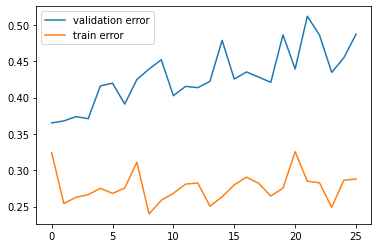

time: 125 ms


In [ ]:
# Plot training and validation errors
plt.subplot()
plt.plot(epochs, validation_error, label='validation error')
plt.plot(epochs, train_error, label='train error')
plt.legend()
plt.show()

In [ ]:
all_time_best_val = torch.load(model_path + "alltimebest.pt")
all_time_best_val

0.297255

time: 5.16 ms


### Hyperparameter tuning

In [ ]:
# Specify parameters and distributions to sample from
hp_lr = [1, 0.7, 0.5, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
hp_momentum = [1, 0.7, 0.5, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
hp_weight_decay = [1, 0.7, 0.5, 0.3, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
hp_batch_size = [1, 2, 4, 6]
hp_optimizer = ["SGD", "Adam"]

time: 2.88 ms


In [ ]:
# Specify number of searches and epochs
num_searches = 50
epochs_pr_search = 20
print("You are running a total of: ", num_searches*epochs_pr_search, "epochs")

You are running a total of:  1000 epochs
time: 1.87 ms


In [ ]:
results = random_search(hp_lr = hp_lr, 
                        hp_momentum = hp_momentum, 
                        hp_weight_decay = hp_weight_decay, 
                        hp_batch_size = hp_batch_size, 
                        hp_optimizer = hp_optimizer, 
                        epochs_pr_search = epochs_pr_search, 
                        num_searches = num_searches, 
                        dataset = dataset_train, 
                        model_path = model_path,
                        net = net)

###### 0 / 20 epochs completed ######
CURRENT TRAIN ERROR:  0.70359015


KeyboardInterrupt: ignored

time: 5.8 s


 # $\color{orange}{\text{Evaluation / Testing}}$

 ## $\color{purple}{\text{Functions}}$

### 1. Test loop

In [33]:
def test(dataset, net):

  # Initiate
  net.eval()
  criterion = nn.BCELoss()
  test_error = []
  count = []
  f1 = []
  f1_obj = []
  hausdorff_obj_distance = []


  for i in range(dataset.__len__()):

    # Get image and target
    image, target = dataset.__getitem__(i)

    # Reshape and cast to gpu to fit model
    image = image.reshape(1, 3, 512, 512)
    image = image.type(torch.cuda.FloatTensor)
    target = target['mask'].reshape(1, 1, 512, 512)
    target = to_cuda(target)

    # Predict
    output = net(image)

    # Calcualte loss
    loss = criterion(output, target)

    test_error = np.append(test_error, get_numpy(loss.data))

    # Prepare images for metrics
    output = output.reshape(512,512).cpu().detach().numpy()
    output = np.uint8(np.array([np.where(l >= 0.5,1,0) for l in output]))
    target = np.uint8(target.reshape(512,512).cpu().detach().numpy())

    # Get metrics
    metrics = BinaryImageMetrics(target, output)

    # Calculate metrics
    count = np.append(count, metrics.get_count())
    f1 = np.append(f1, metrics.get_f1())
    f1_obj = np.append(f1_obj, metrics.get_f1_obj())
    hausdorff_obj_distance = np.append(hausdorff_obj_distance, metrics.get_hausdorff_obj_distance())

    if dataset.__len__()%(i+1) == 0:
      print("Testing: ", i+1,"/", dataset.__len__())

  # Plot Results
  print(np.mean(test_error))
  plt.figure(figsize=(10,5))
  plt.plot(range(len(test_error)), test_error, label='Test Error')
  plt.hlines(np.mean(test_error), 0, dataset.__len__(), label='average')
  plt.legend()
  plt.title('Test Error')
  plt.show()

  print(np.mean(count))
  plt.figure(figsize=(10,5))
  plt.plot(range(len(count)), count, label = 'Count')
  plt.hlines(np.mean(count), 0, dataset.__len__(), label='average')
  plt.legend()
  plt.title('Count Metric')
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(range(len(f1)), f1, label = 'F1')
  plt.hlines(np.mean(f1), 0, dataset.__len__(), label='average')
  plt.legend()
  plt.title('F1 Metric')
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(range(len(f1_obj)), f1_obj, label = 'F1 Object')
  plt.hlines(np.mean(f1_obj), 0, dataset.__len__(), label='average')
  plt.legend()
  plt.title('F1 Object Metric')
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(range(len(hausdorff_obj_distance)), hausdorff_obj_distance, label = 'Hausdorff Object Distance')
  plt.hlines(np.mean(hausdorff_obj_distance), 0, dataset.__len__(), label='average')
  plt.legend()
  plt.title('Hausdorff Object Distance')
  plt.show()

  # Values for return
  count = np.mean(count)
  f1 = np.mean(f1)
  f1_obj = np.mean(f1_obj)
  haus = np.mean(hausdorff_obj_distance)

  return test_error, count, f1, f1_obj, haus

time: 86.5 ms


### 2. Show best prediction

In [20]:
import matplotlib

def prediction_best(test_error, dataset, net):
  # Get data
  min_error_index = np.argmin(test_error)
  image, target = dataset.__getitem__(min_error_index)
  # Get prediction
  image = image.reshape(1, 3, 512, 512)
  image = image.type(torch.cuda.FloatTensor)
  output = net(image)
  best_pred_mask = output.cpu().detach().numpy()
  best_pred_mask = best_pred_mask.reshape(512,512)
  best_pred_mask = np.array([np.where(l >= 0.5,1,0) for l in best_pred_mask])
  original_mask = target['mask'].numpy().reshape(512, 512)
  
  # Print predicted and original
  print('Predicted Mask')
  plt.imshow(best_pred_mask,cmap = 'gray')
  plt.axis('off')
  plt.show()

  print('Original Mask')
  plt.imshow(original_mask, cmap = 'gray')
  plt.axis('off')
  plt.show()

  # For poster
  print(min_error_index)
  matplotlib.image.imsave('Best_pred_mask.png', best_pred_mask, cmap = 'gray')
  matplotlib.image.imsave('bestOriginal_mask.png', original_mask, cmap = 'gray')

time: 19.1 ms


### 3. Show average prediction

In [21]:
def prediction_avg(test_error, dataset, net):
  # Get data
  avg_error_index = find_nearest(test_error, np.mean(test_error))
  image, target = dataset.__getitem__(avg_error_index)

  # Get prediction
  image = image.reshape(1, 3, 512, 512)
  image = image.type(torch.cuda.FloatTensor)
  output = net(image)
  avg_pred_mask = output.cpu().detach().numpy()
  avg_pred_mask = avg_pred_mask.reshape(512,512)
  avg_pred_mask = np.array([np.where(l >= 0.5,1,0) for l in avg_pred_mask])
  original_mask = target['mask'].numpy().reshape(512, 512)

  # Print predicted and original
  print('Predicted Mask')
  plt.imshow(avg_pred_mask,cmap = 'gray')
  plt.axis('off')
  plt.show()

  print('Original Mask')
  plt.imshow(original_mask, cmap = 'gray')
  plt.axis('off')
  plt.show()

  # For poster
  print(avg_error_index)
  matplotlib.image.imsave('avg_pred_mask.png', avg_pred_mask, cmap = 'gray')
  matplotlib.image.imsave('avgOriginal_mask.png', original_mask, cmap = 'gray')

time: 15.6 ms


### 4. Show worst prediction

In [22]:
def prediction_worst(test_error, dataset, net):
  # Get data
  max_error_index = np.argmax(test_error)
  image, target = dataset.__getitem__(max_error_index)

  # Get prediction
  image = image.reshape(1, 3, 512, 512)
  image = image.type(torch.cuda.FloatTensor)
  output = net(image)
  worst_pred_mask = output.cpu().detach().numpy()
  worst_pred_mask = worst_pred_mask.reshape(512,512)
  worst_pred_mask = np.array([np.where(l >= 0.5,1,0) for l in worst_pred_mask])
  original_mask = target['mask'].numpy().reshape(512, 512)

  # Print predicted and original
  print('Predicted Mask')
  plt.imshow(worst_pred_mask,cmap = 'gray')
  plt.axis('off')
  plt.show()

  print('Original Mask')
  plt.imshow(original_mask, cmap = 'gray')
  plt.axis('off')
  plt.show()

  # For poster
  print(max_error_index)
  matplotlib.image.imsave('worst_pred_mask.png', worst_pred_mask, cmap = 'gray')
  matplotlib.image.imsave('worstOriginal_mask.png', original_mask, cmap = 'gray')


time: 23 ms


### 5. Benchmark

In [23]:
def benchmark_results(unet, maskrcnn):

  # Input data from paper
  comparison = {'F1_A_SCORE' : [0.912, 0.891, 0.896, 0.870, 0.868, 0.892, 0.834, 0.652, 0.777, 0.635, np.nan, np.nan],
                'F1_A_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'F1_B_SCORE' : [0.716, 0.703, 0.719, 0.695, 0.769, 0.686, 0.605, 0.541, 0.306, 0.527, np.nan, np.nan],
                'F1_B_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'F1_OBJ_A_SCORE' : [0.897, 0.882, 0.886, 0.876, 0.867, 0.884, 0.875, 0.644, 0.781, 0.737, np.nan, np.nan],
                'F1_OBJ_A_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'F1_OBJ_B_SCORE' : [0.781, 0.786, 0.765, 0.786, 0.800, 0.754, 0.783, 0.654, 0.617, 0.610, np.nan, np.nan],
                'F1_OBJ_B_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'HAUS_A_SCORE' : [45.418, 57.413, 57.350, 57.093, 74.596, 54.785, 57.194, 155.433, 112.706, 107.491, np.nan, np.nan],
                'HAUS_A_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                'HAUS_B_SCORE' : [160.347, 145.575, 159.873, 148.463, 153.646, 187.442, 146.607, 176.244, 190.447, 210.105, np.nan, np.nan],
                'HAUS_B_RANK' : [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
               }

  comparison = pd.DataFrame(comparison, index = ["CUMedVision2", "ExB1", "ExB3", "Freiburg2", "CUMedVision1", "ExB2", "Freiburg1", "CVML", "LIB", "vision4GlaS", "DTU-UNET", "DTU-MASKRCNN"])

  # Add Unet data
  comparison.loc['DTU-UNET', 'F1_A_SCORE'] = unet[0]
  comparison.loc['DTU-UNET', 'F1_B_SCORE'] = unet[1]
  comparison.loc['DTU-UNET', 'F1_OBJ_A_SCORE'] = unet[2]
  comparison.loc['DTU-UNET', 'F1_OBJ_B_SCORE'] = unet[3]
  comparison.loc['DTU-UNET', 'HAUS_A_SCORE'] = unet[4]
  comparison.loc['DTU-UNET', 'HAUS_B_SCORE'] = unet[5]

  # Add Maskrcnn data
  comparison.loc['DTU-MASKRCNN', 'F1_A_SCORE'] = maskrcnn[0]
  comparison.loc['DTU-MASKRCNN', 'F1_B_SCORE'] = maskrcnn[1]
  comparison.loc['DTU-MASKRCNN', 'F1_OBJ_A_SCORE'] = maskrcnn[2]
  comparison.loc['DTU-MASKRCNN', 'F1_OBJ_B_SCORE'] = maskrcnn[3]
  comparison.loc['DTU-MASKRCNN', 'HAUS_A_SCORE'] = maskrcnn[4]
  comparison.loc['DTU-MASKRCNN', 'HAUS_B_SCORE'] = maskrcnn[5]

  # Assign ranks
  # F1 A
  comparison = comparison.sort_values(by = 'F1_A_SCORE', ascending = False)
  i = 1
  for index, row in comparison.iterrows():
    row['F1_A_RANK'] = i
    i += 1
  # F1 B
  comparison = comparison.sort_values(by = 'F1_B_SCORE', ascending = False)
  i = 1
  for index, row in comparison.iterrows():
    row['F1_B_RANK'] = i
    i += 1
  # F1_OBJ A
  comparison = comparison.sort_values(by = 'F1_OBJ_A_SCORE', ascending = False)
  i = 1
  for index, row in comparison.iterrows():
    row['F1_OBJ_A_RANK'] = i
    i += 1
  # F1_OBJ B
  comparison = comparison.sort_values(by = 'F1_OBJ_B_SCORE', ascending = False)
  i = 1
  for index, row in comparison.iterrows():
    row['F1_OBJ_B_RANK'] = i
    i += 1
  # HAUS A
  comparison = comparison.sort_values(by = 'HAUS_A_SCORE', ascending = True)
  i = 1
  for index, row in comparison.iterrows():
    row['HAUS_A_RANK'] = i
    i += 1
  # HAUS B
  comparison = comparison.sort_values(by = 'HAUS_B_SCORE', ascending = True)
  i = 1
  for index, row in comparison.iterrows():
    row['HAUS_B_RANK'] = i
    i += 1
  # Summary
  comparison['FINAL_RANK'] = comparison['F1_A_RANK'] + comparison['F1_B_RANK'] + comparison['F1_OBJ_A_RANK'] + comparison['F1_OBJ_B_RANK'] + comparison['HAUS_A_RANK'] + comparison['HAUS_B_RANK']
  comparison = comparison.sort_values(by = 'FINAL_RANK', ascending = True)

  return comparison


time: 113 ms


 ## $\color{purple}{\text{Execute}}$

### Testset A 

Testing:  1 / 60
Testing:  2 / 60
Testing:  3 / 60
Testing:  4 / 60
Testing:  5 / 60
Testing:  6 / 60
Testing:  10 / 60
Testing:  12 / 60
Testing:  15 / 60
Testing:  20 / 60
Testing:  30 / 60
Testing:  60 / 60
0.4029850302884976


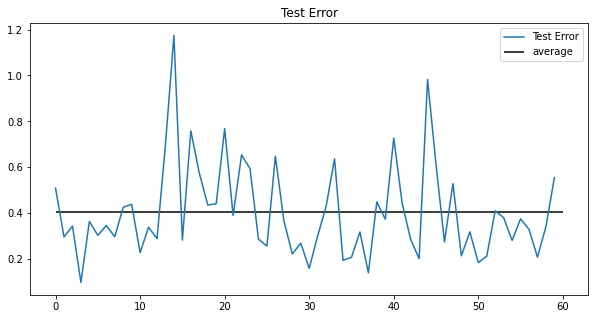

0.21072863876684073


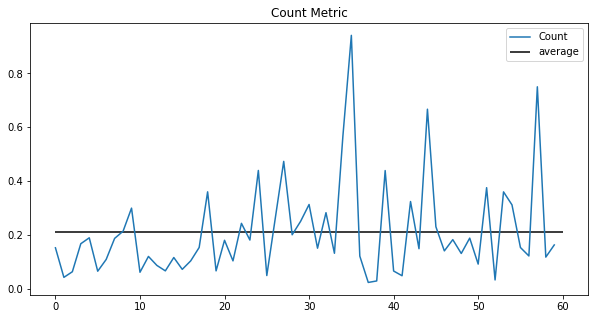

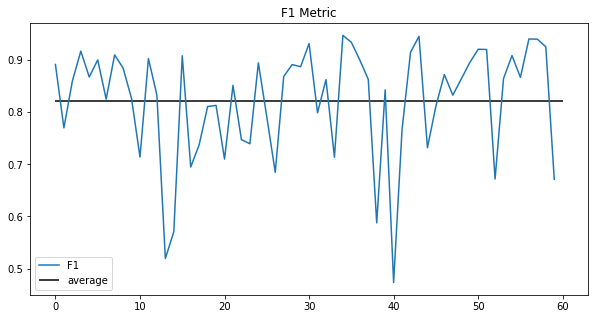

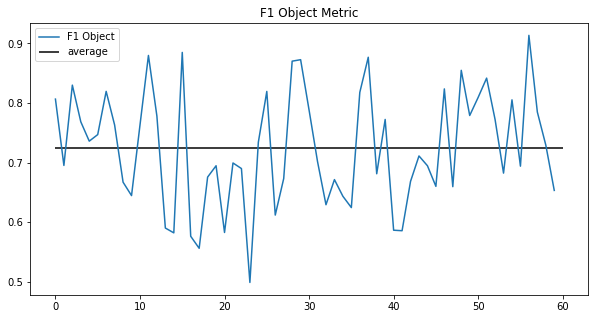

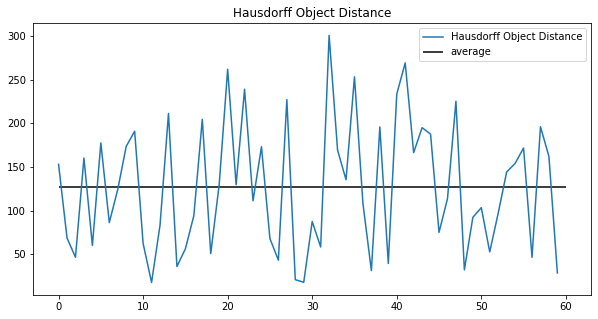

time: 1min 18s


In [34]:
test_error_A, count_A, f1_A, f1_obj_A, haus_A = test(dataset_testA, net)

Predicted Mask


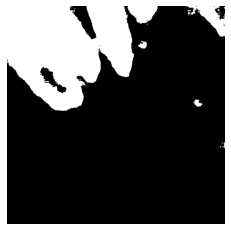

Original Mask


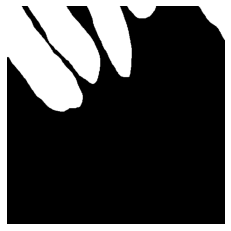

3
time: 429 ms


In [35]:
prediction_best(test_error_A, dataset_testA, net)

Predicted Mask


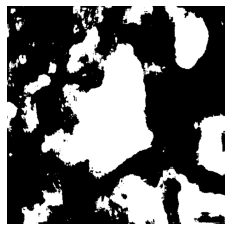

Original Mask


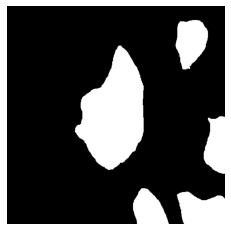

52
time: 420 ms


In [36]:
prediction_avg(test_error_A, dataset_testA, net)

Predicted Mask


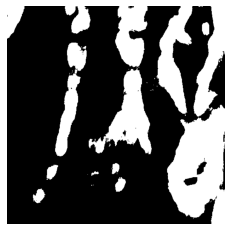

Original Mask


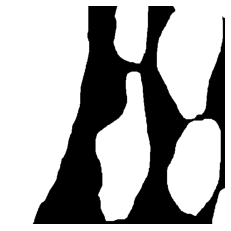

14
time: 463 ms


In [37]:
prediction_worst(test_error_A, dataset_testA, net)

### Testset B

Testing:  1 / 20
Testing:  2 / 20
Testing:  4 / 20
Testing:  5 / 20
Testing:  10 / 20
Testing:  20 / 20
0.38040885999798774


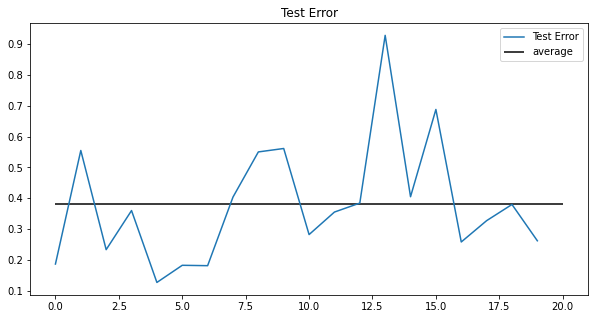

0.12702276000967744


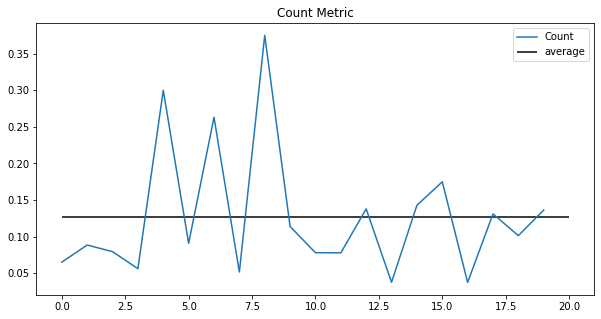

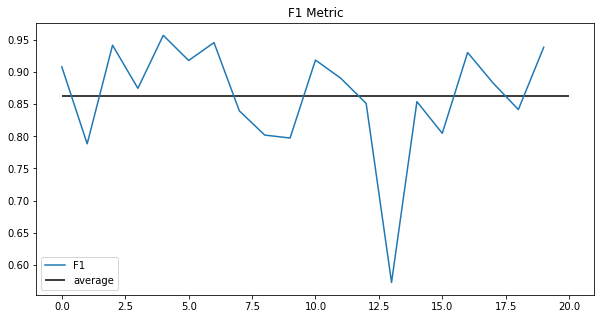

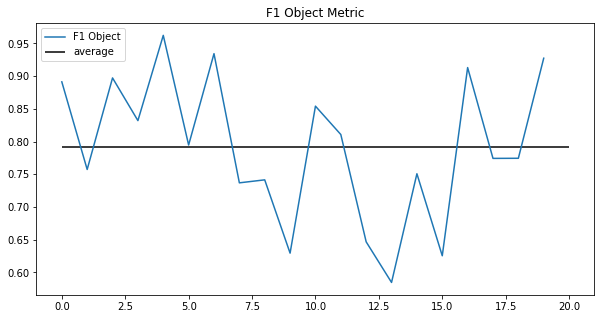

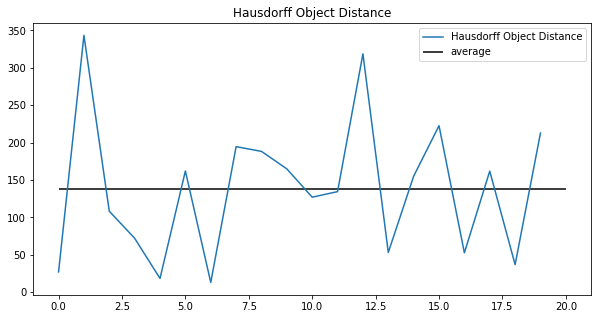

time: 31.5 s


In [38]:
test_error_B, count_B, f1_B, f1_obj_B, haus_B = test(dataset_testB, net)

Predicted Mask


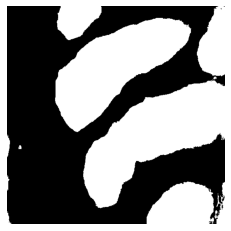

Original Mask


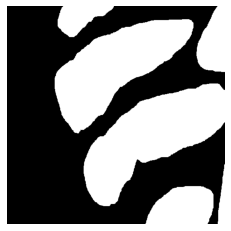

4
time: 433 ms


In [39]:
prediction_best(test_error_B, dataset_testB, net)

Predicted Mask


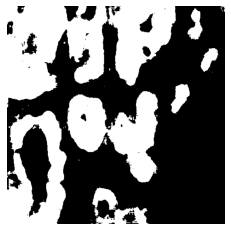

Original Mask


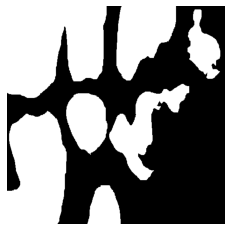

18
time: 414 ms


In [40]:
prediction_avg(test_error_B, dataset_testB, net)

Predicted Mask


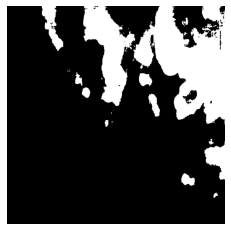

Original Mask


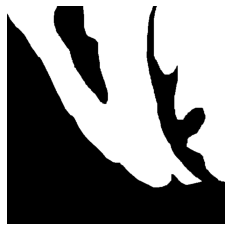

13
time: 405 ms


In [41]:
prediction_worst(test_error_B, dataset_testB, net)

### Benchmark

In [32]:
benchmark_results(unet = [f1_A, f1_B, f1_obj_A, f1_obj_B, haus_A, haus_B], maskrcnn = [0.9222171412764933,0.9068564942876133,0.9051972204094346,0.8720662011696115,37.529664637018506,74.2874632918737])

,F1_A_SCORE,F1_A_RANK,F1_B_SCORE,F1_B_RANK,F1_OBJ_A_SCORE,F1_OBJ_A_RANK,F1_OBJ_B_SCORE,F1_OBJ_B_RANK,HAUS_A_SCORE,HAUS_A_RANK,HAUS_B_SCORE,HAUS_B_RANK,FINAL_RANK
DTU-MASKRCNN,0.922217,1.0,0.906856,1.0,0.905197,1.0,0.872066,1.0,37.529665,1.0,74.287463,1.0,6.0
CUMedVision2,0.912000,2.0,0.716000,5.0,0.897000,2.0,0.781000,7.0,45.418000,2.0,160.347000,8.0,26.0
ExB1,0.891000,5.0,0.703000,6.0,0.882000,5.0,0.786000,4.0,57.413000,7.0,145.575000,3.0,30.0
ExB3,0.896000,3.0,0.719000,4.0,0.886000,3.0,0.765000,8.0,57.350000,6.0,159.873000,7.0,31.0
Freiburg2,0.870000,6.0,0.695000,7.0,0.876000,6.0,0.786000,5.0,57.093000,4.0,148.463000,5.0,33.0
CUMedVision1,0.868000,7.0,0.769000,3.0,0.867000,8.0,0.800000,2.0,74.596000,8.0,153.646000,6.0,34.0
DTU-UNET,0.822367,9.0,0.862875,2.0,0.723707,11.0,0.791896,3.0,126.685792,11.0,138.294914,2.0,38.0
ExB2,0.892000,4.0,0.686000,8.0,0.884000,4.0,0.754000,9.0,54.785000,3.0,187.442000,10.0,38.0
Freiburg1,0.834000,8.0,0.605000,9.0,0.875000,7.0,0.783000,6.0,57.194000,5.0,146.607000,4.0,39.0
LIB,0.777000,10.0,0.306000,12.0,0.781000,9.0,0.617000,11.0,112.706000,10.0,190.447000,11.0,63.0


time: 78.4 ms
